# Galactic vs Stock Talk

**My Automoderator is the future of the internet but still deeply imperfect**

![](https://cdn0.tnwcdn.com/wp-content/blogs.dir/1/files/2019/08/reddit-deleted-posts-comments-threads-796x450.jpg)



*Humans and Technology...what's the worst that could happen?*
-------------------------------------------------------------------------------
**Banishing Tin foilers and tracking down Ponzies— Reporting for duty on the front lines, within the social site’s volunteer army.**


# Background:

**I’m a moderator for a popular Finance related subreddit….I’m lazy, so I built a script/model to detect non-related posts and automatically remove it from my precious forum.**


# Problem Statement:

Could I build an NLP model that reduces tinfoil posts on my assigned subreddit with high degree of accuracy? 


# Data:

  - Reddit SubReddit Posts in the following;
  
	- Aliens SubReddit
	- Stocks SubReddit

 
| Index | title | subreddit | 
| --- | --- | --- |
| **0** | Prophet Yahweh summons UFO for ABC News | Aliens |
| **1** | What's the best defense sector company to invest in? | Stocks | 

  
# Methodology:

  - Data Cleaning - Removed Https, www, white spaces, symbols etc.
  - PRAW - Data Sourcing
  - NLP - Word Tokenizers
  - Modeling - Classification models
 

# EDA:

- Just, Like , Year were very common in both Aliens and Stocks reddits

- See EDA workbook in notebooks folder in for visuals 


# Data Preprocessing:

   - Vectorizing - Countvectorizer , TfidfVectorizer
   
   Params = english stop words + ha, wa, im, doe , max_features=5000
  
   - RegexpTokenizer
   
   - WordNetLemmatizer
   
   
# Modeling:
  - Features = title
  - Models used = Log Reg, Random Forest, SVM C
  - Gridsearching + hyperparameter tuning
  
  
# Conclusions:
  - Overall my accuracy increased from Log reg(first model) to SVM my final model
  - Its safe to say Aliens and Stocks being the top words in their respective categorys helped classify the post 
  - My aim was to maximise PPV or recall, it was achieved through the svm model with params {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'} and TfidfVectorizer params 'english' stop words + "ha",'wa','im','doe'.
  
  
# Next Steps:
  - Remove common words that appear in greater frequencies in both subreddits
  - Add some numerical features such as title length and upper case words vs lower case
    

## Imports + Python Reddit API Wrapper (PRAW)

In [1]:
import praw
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import text

from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from jupyterthemes import jtplot
jtplot.style()

pd.options.display.max_colwidth = 400

In [2]:
# interface with Reddit API
reddit = praw.Reddit(client_id = 'XHsZZVSjfSABiw',     
                     client_secret = 'JihIFf816GAS2_9Nfc0VvtRUeqM', 
                     user_agent = 'scrap1',    #my app
                     username = 'jbroche23',      
                     password = 'sybxog-2pokpo-fofJip')      

#pick the name of a subreddit
aliens_subreddit = reddit.subreddit('aliens')    
stock_subreddit = reddit.subreddit('stocks')

#Specify what type of posts from subreddits to pull - New = latest
AL_subreddit_new = aliens_subreddit.new(limit = 1000)
ST_subreddit_new = stock_subreddit.new(limit = 1000)

#Specify what type of posts from subreddits to pull - Gilded = user voted as top
#AL_subreddit_gild = aliens_subreddit.new(limit = 1000)
#ST_subreddit_gild = stock_subreddit.new(limit = 1000)

#Specify what type of posts from subreddits to pull - New = latest
#AL_subreddit_hot = aliens_subreddit.new(limit = 1000)
#ST_subreddit_hot = stock_subreddit.new(limit = 1000)

topics_dict = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

topics_dict2 = { "title":[],
                "score":[],
                "id":[],
                "url":[], 
                "comms_num": [],
                "created": [],
                "body":[]}

#Use a for loop to take the posts gathered by the wrapper and place them into a dictionary.
for item in AL_subreddit_new:
    topics_dict["title"].append(item.title)
    topics_dict["score"].append(item.score)
    topics_dict["id"].append(item.id)
    topics_dict["url"].append(item.url)
    topics_dict["comms_num"].append(item.num_comments)
    topics_dict["created"].append(item.created)
    topics_dict["body"].append(item.selftext)

for item in ST_subreddit_new:
    topics_dict2["title"].append(item.title)
    topics_dict2["score"].append(item.score)
    topics_dict2["id"].append(item.id)
    topics_dict2["url"].append(item.url)
    topics_dict2["comms_num"].append(item.num_comments)
    topics_dict2["created"].append(item.created)
    topics_dict2["body"].append(item.selftext)


# Load Data

In [3]:
#Dfs
df = pd.DataFrame(topics_dict)
df2 = pd.DataFrame(topics_dict2)

#create target label cols
df['subreddit'] = 'aliens'
df2['subreddit'] = 'stocks'

# concat my dfs
dfconcat = pd.concat([df,df2])
dfconcatcopy = dfconcat.copy()

#drop cols
dfconcat.drop(columns=['url','created','score','comms_num'],inplace=True)
dfconcat.drop_duplicates(['id'])

#map cols
dfconcat['subreddit'] = dfconcat['subreddit'].map({'aliens': 0, 'stocks': 1})

In [4]:
df.head(1).transpose()

,0
title,Prophet Yahweh summons UFO for ABC News
score,1
id,jfkuof
url,https://youtu.be/haCcvnFJdNk
comms_num,0
created,1.60334e+09
body,
subreddit,aliens


In [5]:
df2.head(1).transpose()

,0
title,What's the best defense sector company to invest in?
score,1
id,jfkukm
url,https://www.reddit.com/r/stocks/comments/jfkukm/whats_the_best_defense_sector_company_to_invest_in/
comms_num,0
created,1.60334e+09
body,"It is to my understanding that in general terms , military budget expenditure is unlikely to decrease in the oncoming nears due to rise of China/ Russia/ insert other hostile nation. Budget increases in military spending with a few competitors and high barriers to entry make it a relatively lucrative area to invest in. I'm currently looking between these 4 separate companies with a bunch of he..."
subreddit,stocks


In [6]:
dfconcat['subreddit'].value_counts()

1    990
0    911
Name: subreddit, dtype: int64

In [7]:
dfconcat['subreddit'].value_counts(normalize=True)

1    0.520779
0    0.479221
Name: subreddit, dtype: float64

# PreProcessing

In [8]:
# outbalanced classes need oversampling
df_pos = dfconcat[dfconcat['subreddit'] == 0]

df_pos = df_pos.sample(84) # 84 because the class unbalance = 84

df_final = pd.concat([dfconcat,df_pos],axis=0)

In [9]:
df_final.head(1).transpose()

,0
title,Prophet Yahweh summons UFO for ABC News
id,jfkuof
body,
subreddit,0


In [10]:
#classes balanced
print(f'DF shape before Target balance: {dfconcat.shape} ')
print(f'DF shape after Target balance: {df_final.shape} ')      

DF shape before Target balance: (1901, 4) 
DF shape after Target balance: (1985, 4) 


In [11]:
df_final['title'] = df_final['title'].replace('\nhttp\S+', '', regex=True).replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n\S+', '', regex=True).replace('#\S+','', regex = True).replace('@\S+', '', regex=True)
df_final['body'] = df_final['body'].replace('\nhttp\S+', '', regex=True).replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n\S+', '', regex=True).replace('#\S+','', regex = True).replace('@\S+', '', regex=True)

In [12]:
# Heathers Code from NLP lesson

lemmer = WordNetLemmatizer()  #instantiate stemmer

def remove_punctuation(text):
    lower = text.lower()  
    exclude = string.punctuation  #identifies punctuation marks
    return "".join(ch for ch in lower if ch not in exclude) 
   #this iterates through each character, if the character is not a punctuation mark it will join to the empty string

df_final['title'] = df_final['body'].apply(remove_punctuation)
df_final['body'] = df_final['body'].apply(remove_punctuation)


In [13]:
# Heathers Code from NLP lesson

def split_and_stem(string):
    word = ""   #empty string
    string = string.split(' ') #creates list of words
    for i in string: #iterates through that list of words
        word += (lemmer.lemmatize(i) + " ")  #stems each word and adds to empty string
    return word  #returns string with stemmed words

df_final['title'] = df_final['title'].apply(split_and_stem)
df_final['body'] = df_final['body'].apply(split_and_stem)

In [14]:
df_finalcopy = df_final.copy()

In [15]:
df_finalcopy.head(5).transpose()

,0,1,2,3,4
title,,,i went on a long rant in reply to that post and felt strongly about the relevance of making my reply an actual post it a bit of a read but please stay with me post here this is what legit ufo footage should look like someone who sifts through about anywhere from 5 to 15 or more ufo sighting submission footage segment a day i can tell you that clear legit ufo footage when it doe materialize ei...,2 intriguing ufo video footage segment recently submitted to mufon source chapter index provided at bottom of post in san ramon and palm spring california first segment is filmed at night and the second segment is a daylight captured by a lady taking her dog for a walk first video segment is the most anomalous and unusual looking however if it were rotated 120 degree clockwise it would have q...,
id,jfkuof,jfkeq3,jfh03c,jffn03,jff7h3
body,,,i went on a long rant in reply to that post and felt strongly about the relevance of making my reply an actual post it a bit of a read but please stay with me post here this is what legit ufo footage should look like someone who sifts through about anywhere from 5 to 15 or more ufo sighting submission footage segment a day i can tell you that clear legit ufo footage when it doe materialize ei...,2 intriguing ufo video footage segment recently submitted to mufon source chapter index provided at bottom of post in san ramon and palm spring california first segment is filmed at night and the second segment is a daylight captured by a lady taking her dog for a walk first video segment is the most anomalous and unusual looking however if it were rotated 120 degree clockwise it would have q...,
subreddit,0,0,0,0,0


# PreProcessing + Modeling

In [16]:
X = df_final['title']
y = df_final['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 63,
                                                    stratify = y )

In [17]:
y_train.mean(), y_test.mean()

(0.49887133182844245, 0.49847560975609756)

In [18]:
X_train.shape , X_test.shape

((1329,), (656,))

In [19]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["ha",'wa','im','doe'])

cv = CountVectorizer(stop_words=my_stop_words,max_features=5000)

cv.fit(X_train)

X_train_cv = cv.transform(X_train)

X_test_cv = cv.transform(X_test)

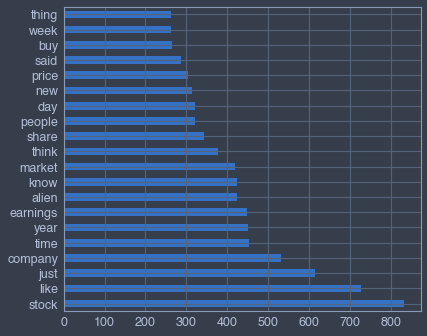

In [20]:
# this is just to visualize what is happening
X_train_df = pd.DataFrame(X_train_cv.todense(), 
                          columns=cv.get_feature_names())
# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');

In [21]:
X_train_df.shape

(1329, 5000)

#  Baseline model = LogReg

In [22]:
lr = LogisticRegression()

lr.fit(X_train_cv,y_train)

# Evaluate
lr.score(X_train_cv, y_train) , lr.score(X_test_cv, y_test)

(0.9969902182091799, 0.9573170731707317)

In [23]:
# Evaluate against the baseline
y_test.value_counts(normalize=True)

0    0.501524
1    0.498476
Name: subreddit, dtype: float64

In [24]:
y_train.value_counts(normalize=True)

0    0.501129
1    0.498871
Name: subreddit, dtype: float64

# Evaluate Model Metrics

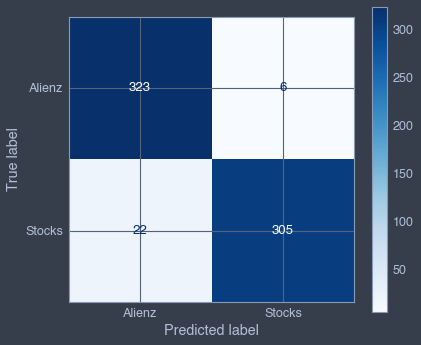

In [33]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

# Generate predictions.
preds = lr.predict(X_test_cv)
pred_proba = lr.predict_proba(X_test_cv)[:,1]

def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Predicted Alienz', 'Predicted Stonks'], 
                            columns=['Actual Alienz', 'Actual Stonks']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))

plot_confusion_matrix(lr, X_test_cv, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Alienz', 'Stocks']);

In [30]:
metrics(y_test, preds, pred_proba)

Accuracy score 0.9573170731707317  

----------------------------------------------------------------
                  Actual Alienz  Actual Stonks
Predicted Alienz            323              6
Predicted Stonks             22            305 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       329
           1       0.98      0.93      0.96       327

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656

-----------------------------------------------------------------
ROC_AUC SCORE 0.9948133069351105 


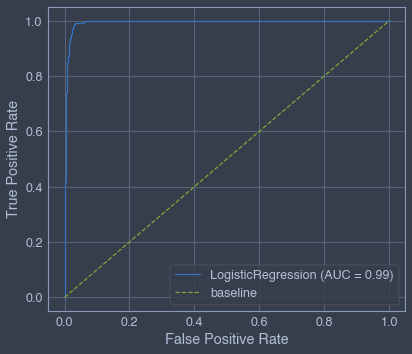

In [34]:
plot_roc_curve(lr, X_test_cv, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();


In [28]:
#df_finalcopy.to_csv('../project_3/ALvsST.csv',index=False)